In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('olmo')

In [2]:
Rd = 1.29 # [m] Radius of the detector
HL_d = 3. # [m] half lenght of the detector
c_light = 2.99792458E8 #m/s
Bz = 3.8  #T
sigma_TOF =  35E-12 #[s]

Probability of detecting a mass M with the given resolution

In [3]:
p_avg = 100 #average_momentum
TOF_avg = np.hypot(Rd, HL_d)/c_light
epsilon = sigma_TOF/TOF_avg
print epsilon

0.0032131177613906234


In [4]:
def Prob(m, p, epsilon):
    z = np.sqrt(np.square(m)/p**2 + 1)
    aux = m * np.exp(-(z-1)**2/(2*epsilon**2))
    aux /= np.sqrt(2*np.pi) * p**2 * epsilon * z
    return aux

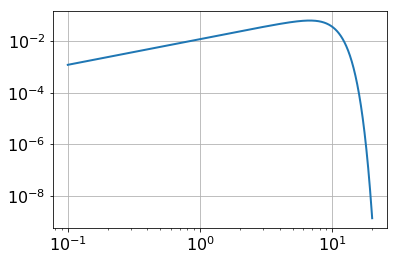

In [5]:
mass = np.logspace(np.log10(0.1), np.log10(20), 1000)

prob = Prob(mass, p=p_avg, epsilon=epsilon)

plt.plot(mass, prob)
plt.grid()
plt.xscale('log')
plt.yscale('log')

Discrimination power a a function of momentum

In [6]:
Mass = {'Pion': 0.139570, 'Kaon': 0.493, 'Proton': 0.938, 'Muon': 0.105, 'Electron': 0.000511}

In [7]:
def Eta2Theta(eta):
    return 2*np.arctan(np.exp(-eta))

In [8]:
#Assume production ar r = (0,0,0) and phi = 0
#pt in GeV
def Compute_Phi_out(pt, eta):
    rh = 1.0E9 * pt / (Bz * c_light)
    pz = 1.0E9 * pt / np.tan(Eta2Theta(eta))
    phi_endcap = HL_d * Bz * c_light / pz
    cos_phi = 1 - Rd**2 / (2 * rh**2)
    phi_barrel =  np.arccos(cos_phi)
    
    minimum_angle = np.minimum(phi_endcap, phi_barrel)
    return np.where(2*rh < Rd, phi_endcap, minimum_angle)

In [9]:
def Compute_L(pt, eta):
    rh = 1.0E9 * pt / (Bz * c_light)
    ctg_theta = 1 / np.tan(Eta2Theta(eta))
    phi_out = Compute_Phi_out(pt, eta)
    return rh * np.sqrt(1 + ctg_theta**2) * phi_out

In [10]:
Compute_L(1,0)

1.449000616223639

In [11]:
def TOF_resolved_mass(pt, eta, sigma_TOF, m_ref = 0., sigma = 3):
    L = Compute_L(pt, eta)
    ctg_theta = 1 / np.tan(Eta2Theta(eta))
    p = pt * np.sqrt(1 + ctg_theta**2)
    aux1 = np.square(np.sqrt(1 + m_ref**2/p**2) + sigma * c_light * sigma_TOF/L) - 1
    min_mass = np.sqrt(aux1) * p
    aux2 = np.square(np.sqrt(1 + m_ref**2/p**2) - sigma * c_light * sigma_TOF/L) - 1
    max_mass = np.sqrt(aux2) * p
    return np.column_stack((min_mass, max_mass))

In [12]:
TOF_resolved_mass(np.array([1,3,6]),1, sigma_TOF, m_ref = 0.13)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


array([[0.29095268,        nan],
       [0.83263918,        nan],
       [1.6561291 ,        nan]])

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in arccos
  
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


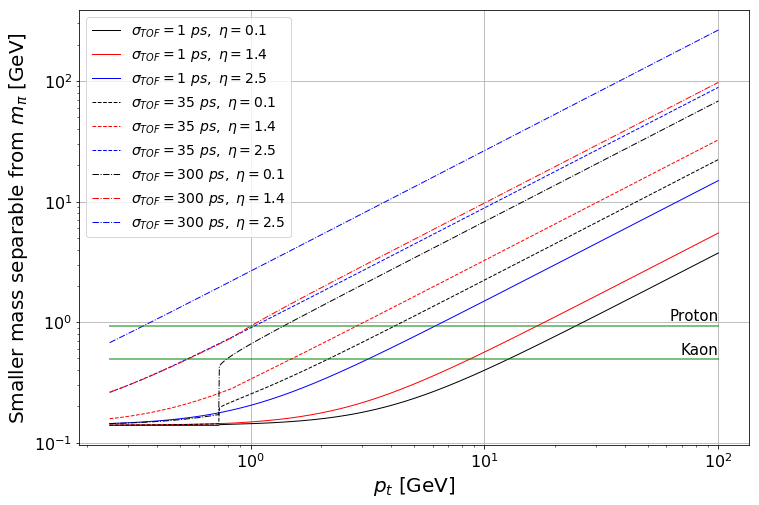

In [53]:
Ref = 'Pion'
M_ref = Mass[Ref]
sigma = 3
pt_range = np.logspace(np.log10(0.25), np.log10(100), 1000)

mass_min = {}
mass_max = {}
eta_list = [0.1, 1.4, 2.5]
# eta_list = [1.4]
plt.figure(figsize=(12,8))
color = 'krb'
style = ['', '--', '-.']

for i, sigma_TOF in enumerate([1.E-12, 35.E-12, 300.E-12]):
    mass_min[sigma_TOF] = {}
    mass_max[sigma_TOF] = {}
    for j, eta in enumerate(eta_list):
        out = TOF_resolved_mass(pt_range, eta, sigma_TOF, M_ref, sigma)
        m1 = out[:,0]
        m2 = out[:,1]

        plt.plot(pt_range, m1,
                 color[j]+style[i], lw=1,
                 label=r'$\sigma_{{TOF}} = {:.0f}\ ps ,\ \eta = {:.1f}$'.format(1E12*sigma_TOF, eta))
        
#         plt.plot(pt_range, m2,
#                  color[j]+style[i],
#                  label=r'$\sigma TOF = {:.0f} ps ,\eta = {:.1f}$'.format(1E12*sigma_TOF, eta))

        
font = {
        'color':  'gray',
        'weight': 'normal',
        'size': 20,
        }
for name, m in Mass.iteritems():
    if m>M_ref:
        plt.plot(pt_range, [m]*pt_range.shape[0], 'g', lw=2, alpha=0.5)
        plt.text(pt_range[-1], m*1.1, name, ha='right', size=15)
    
plt.legend(loc='best', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$p_t$ [GeV]')
plt.ylabel(r'Smaller mass separable from $m_\pi$ [GeV]')
# plt.title(r'Mass required ${}\sigma$ significance from {}'.format(sigma, Ref))
plt.grid()


# i_x = int(pt_range.size*0.5)
# i_y = int(pt_range.size*0.95)
# plt.text(pt_range[i_x], mass[eta_list[-1]][i_y], 
#          r'TOF resolution {:.0f} ps'.format(sigma_TOF*1E12), 
#          fontdict=font,
#          ha="center", va="center",
#          bbox=dict(boxstyle="square",
#                    fc=(1., 1., 1.),
#                    ec=(0., 0., 0.),
#                    ));
plt.savefig('../_fig/Limit_Mass_vs_Pt.png')

In [28]:
def sigmaPT_o_PT(pt):
    return np.where( pt < 134.7, 0.013*np.ones_like(pt), 0.011 * pt / 134.7)

In [37]:
def Mass_uncertainty(m, pt, eta, sigma_TOF = 35e-12, dL = 3e-3):
    L = Compute_L(pt, eta)
    ctg_theta = 1 / np.tan(Eta2Theta(eta))
    p = pt * np.sqrt(1 + ctg_theta**2)
    
    beta = p / np.hypot(p, m)
    tof = L / (c_light * beta)
    dbeta_o_beta = np.hypot(dL/L, sigma_TOF/tof)
    
    print sigma_TOF/tof
    dm = m * np.hypot( sigmaPT_o_PT(pt), dbeta_o_beta/(1 - np.square(beta)) )

    return dm

In [38]:
masses = np.array([300, 600])
Mass_uncertainty(masses, masses, 1)

[0.00442354 0.00442354]


array([ 8.74568423, 30.88946707])

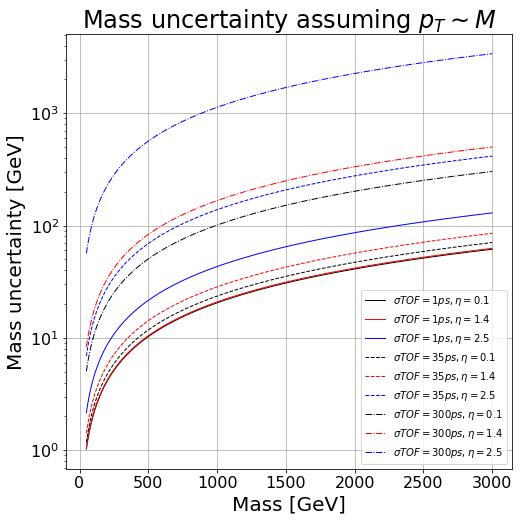

In [36]:
eta_list = [0.1, 1.4, 2.5]
masses = np.logspace(np.log10(50), np.log10(3000), 100)

plt.figure(figsize=(8,8))
color = 'krb'
style = ['', '--', '-.']



for i, sigma_TOF in enumerate([1.E-12, 35.E-12, 300.E-12]):
    
    for j, eta in enumerate(eta_list):
        dm = Mass_uncertainty(masses, masses, eta, sigma_TOF)
        
        plt.plot(masses, dm,
                 color[j]+style[i], lw=1,
                 label=r'$\sigma TOF = {:.0f} ps ,\eta = {:.1f}$'.format(1E12*sigma_TOF, eta))
        
# font = {
#         'color':  'gray',
#         'weight': 'normal',
#         'size': 16,
#         }
# for name, m in Mass.iteritems():
#     if m>M_ref:
#         plt.plot(pt_range, [m]*pt_range.shape[0], 'g', lw=1, alpha=0.5)
#         plt.text(pt_range[-1], m*1.1, name, ha='right')
    
plt.legend(loc='best')
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mass [GeV]')
plt.ylabel('Mass uncertainty [GeV]')
plt.title(r'Mass uncertainty assuming $p_{{T}}\sim M$')
plt.grid()